# State of the art query sampling methods
In this notebook, we propose to test recent query sampling methods from various packages. We load the FashionMNIST dataset.

In [26]:
import openml
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt


dataset = openml.datasets.get_dataset(40996)
X, y, cat_indicator, a = dataset.get_data(dataset_format='array', target=dataset.default_target_attribute)
X = X.astype('float32') / 255.
X = X[:7000]
y = y[:7000]

n_iter = 8
batch_size = 50
total_accuracies = {}
model = RandomForestClassifier(n_estimators=20)

## Baal's BALD

BALD is a Bayesian approach to query strategy. Several implementation are available, we propose to use one from the Baal plugin, specialized in Bayesian method. Note that a batch version of this algorithm called BatchBALD exists but its long computational time makes it unfit for a tutorial.

We propose a wrapper to use this sampler using the cardinal interface. However, this exercise can be made with the wrapper of your chosing among other packages such as modAL or alipy.

In [27]:
from baal.active.heuristics import BALD
from cardinal.base import ScoredQuerySampler
from cardinal.uncertainty import check_proba_estimator
from scipy.special import xlogy



def predict(test, clf):
    # Predict with all fitted estimators.
    x = np.array(list(map(lambda e: e.predict_proba(test), clf.estimators_)))

    # Roll axis because BaaL expect [n_samples, n_classes, ..., n_estimations]
    x = np.rollaxis(x, 0, 3)
    return x


class BALDSampler(ScoredQuerySampler):
    def __init__(self, classifier, batch_size: int,
                 strategy: str = 'top', assume_fitted: bool = False,
                 verbose: int = 0):
        super().__init__(batch_size, strategy=strategy)
        self.classifier_ = classifier
        self.assume_fitted = assume_fitted
        self.verbose = verbose
        if self.classifier_ == 'precomputed':
            self.assume_fitted = True
        else:
            check_proba_estimator(classifier)

    def fit(self, X: np.array, y: np.array) -> 'BALDSampler':
        if not self.assume_fitted:
            self.classifier_.fit(X, y)
        return self

    def score_samples(self, X: np.array) -> np.array:
        predictions = predict(X, self.classifier_)
        expected_entropy = - np.mean(np.sum(xlogy(predictions, predictions), axis=1),
                                     axis=-1)
        expected_p = np.mean(predictions, axis=-1)  # [batch_size, n_classes, ...]
        entropy_expected_p = - np.sum(xlogy(expected_p, expected_p),
                                      axis=1)  # [batch size, ...]
        bald_acq = entropy_expected_p - expected_entropy
        return bald_acq


## K-Center Greedy

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder


class RFEmbedder:

    def __init__(self, model, X_ref):
        self.model = model
        self.X_ref = X_ref

    def __call__(self, X):
        n_leaves = [0] + [i.get_n_leaves() for i in self.model.estimators_]
        self.shifts = np.cumsum(n_leaves)
        data = self.model.apply(self.X_ref)
        self.ohe = OneHotEncoder().fit(data)
        self.pca = TruncatedSVD(n_components=int(np.log(data.shape[1]) / (0.25 ** 2)))
        self.pca.fit(self.ohe.transform(data))

        return self.pca.transform(self.ohe.transform(self.model.apply(X)))


## Cardinal methods

In this section, we focus on two recent methods:
* Diverse mini-batch active learning
* Core-sets (more precisely, k-center greedy)

## Benchmark

We run a benchmark of those methods.

Sampler:  KCenter-Greedy
Sampler:  Random
Sampler:  Margin
Sampler:  WKMeans
Sampler:  BALD


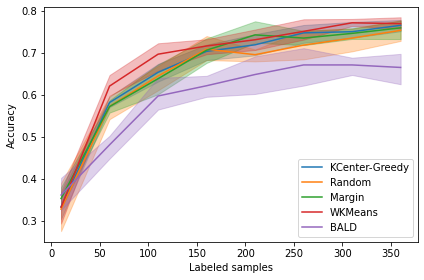

In [29]:
from cardinal.uncertainty import MarginSampler
from cardinal.random import RandomSampler
from cardinal.clustering import KCenterGreedy
from cardinal.zhdanov2019 import TwoStepKMeansSampler
from cardinal.plotting import plot_confidence_interval
from cardinal.utils import ActiveLearningSplitter


samplers = [
    ('KCenter-Greedy', KCenterGreedy(RFEmbedder(model, X), batch_size)),
    ('Random', RandomSampler(batch_size)),
    ('Margin', MarginSampler(model, batch_size, assume_fitted=True)),
    ('WKMeans', TwoStepKMeansSampler(10, model, batch_size, assume_fitted=True)),
    ('BALD', BALDSampler(model, batch_size, assume_fitted=True))
]

figure_accuracies = plt.figure().number
idxs = {}

for sampler_name, sampler in samplers:
    
    print('Sampler: ', sampler_name)
    
    all_accuracies = []

    for k in range(5):
        idx = ActiveLearningSplitter.train_test_split(X.shape[0], test_size=500, random_state=k)

        accuracies = []

        # For simplicity, the first batch is simply one sample from each class
        one_per_class = np.unique(y[idx.non_selected], return_index=True)[1]
        idx.add_batch(one_per_class)

        # A classic active learning loop
        for j in range(n_iter):
            model.fit(X[idx.selected], y[idx.selected])
            accuracies.append(model.score(X[idx.test], y[idx.test]))
            sampler.fit(X[idx.selected], y[idx.selected])
            idx.add_batch(sampler.select_samples(X[idx.non_selected]))

        all_accuracies.append(accuracies)
    
    # Keep the last splitter
    idxs[sampler_name] = idx
    
    x_data = np.arange(10, batch_size * (n_iter - 1) + 11, batch_size)

    plt.figure(figure_accuracies)
    plot_confidence_interval(x_data, all_accuracies, label=sampler_name)

plt.figure(figure_accuracies)
plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

You may observe that this experiment has no clear winner. Let's try to turn the tables!

# Play the devil's advocate

We have now completed two benchmarks with two different datasets and various active learning methods. During the first part, we highlighted that the complexity and subtlety of active learning experiments that makes it easy to have, very locally, one method dominate another.
This is your turn to try to find the best condition for your favorite sampler to appear on top.
- The cell below contains experimental parameters that you are allowed to tune to make your method looks better. Pro-tip: you should consider BALD as a weak contender rather than a champion.
- The next cell will run your experiment and the last one computes a score. If you method outperforms the others, do not hesitate to share it directly on slack!

In [31]:
# You can modify this!

cv_seeds = [0, 1, 2]
batch_size = 80

model = RandomForestClassifier()

samplers = [
    ('Random', RandomSampler(batch_size)),
    ('Margin', MarginSampler(model, batch_size, assume_fitted=True)),
    ('WKMeans', TwoStepKMeansSampler(10, model, batch_size, assume_fitted=True)),
    ('Proposed', YOUR_SAMPLER_HERE)
]


This is the main active learning loop. You should not modify it (or at least do not change the logic).

In [38]:
from sklearn.datasets import load_digits


digits = load_digits()
X, y = load_digits(return_X_y=True)
X /= 255.

n_iter = 10

sampler_accuracies = {}

for sampler_name, sampler in samplers:
    
    print('Sampler: ', sampler_name)
    
    all_accuracies = []

    for seed in cv_seeds:
        idx = ActiveLearningSplitter.train_test_split(X.shape[0], test_size=500, random_state=cv_seeds)

        accuracies = []

        # For simplicity, the first batch is simply one sample from each class
        one_per_class = np.unique(y[idx.non_selected], return_index=True)[1]
        idx.add_batch(one_per_class)

        # A classic active learning loop
        for j in range(n_iter):
            if sampler_name == 'Proposed':
                if j < 3:
                    sampler = samplers[2][1]
                else:
                    sampler = samplers[1][1]
            model.fit(X[idx.selected], y[idx.selected])
            accuracies.append(model.score(X[idx.test], y[idx.test]))
            sampler.fit(X[idx.selected], y[idx.selected])
            idx.add_batch(sampler.select_samples(X[idx.non_selected]))

        all_accuracies.append(accuracies)
    
    sampler_accuracies[sampler_name] = all_accuracies


Sampler:  Random
Sampler:  Margin
Sampler:  WKMeans


/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 800 samples but data only
             has 727. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 800 samples but data only
             has 647. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 800 samples but data only
             has 567. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 800 samples but data only
             has 727. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 800 samples but data

Sampler:  Proposed


This cell displays your results. Use it to overfit!

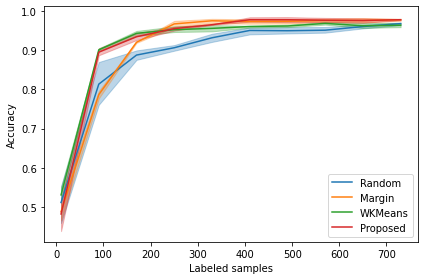

In [39]:
x_data = np.arange(10, batch_size * (n_iter - 1) + 11, batch_size)

for sampler_name in sampler_accuracies:
    plot_confidence_interval(x_data, sampler_accuracies[sampler_name], label=sampler_name)

plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

Here we compute the rank of all methods (statistical significance is not checked). If your method beats

In [44]:
# Rank methods
auc = []
for sampler_name in sampler_accuracies:
    accuracies = sampler_accuracies[sampler_name]
    auc.append((- np.sum(accuracies), sampler_name))
    
auc = sorted(auc)
for i, (_, sampler_name) in enumerate(sorted(auc)):
    print('{}. {}'.format(i + 1, sampler_name))
    
if auc[0][1] != 'Proposed':
    print('Sorry, your method is not the best one, try again!')

score = len(samplers) + len(cv_seeds) + batch_size / 50
print('\nYour score is:', score)

1. Proposed
2. WKMeans
3. Margin
4. Random

Your score is: 8.6
